# アブストラクトの評価指標に関する分析

### 目的

- 良い論文と悪い論文の間で評価指標（rule1 ~ rule31）の差を分析。
- 2 グループ間の有意差を検証。


## データの読み込み


In [7]:
import os
import pandas as pd
from functions import (
    load_data, preprocess_data, calculate_ztest,
    visualize_results, calculate_yes_ratios, save_yes_ratio_graph
)

In [8]:
# パスの設定
data_dir = "../../data/results/combined"
graph_save_dir = "../../data/results/graphs"
data_save_dir = "../../data/results/metrics"

In [9]:
# データ読み込み
high_group, low_group = load_data(data_dir)

## データの分析


In [10]:
# ルールリスト
rules = [f'rule{i}' for i in range(1, 32)]

all_high_df = preprocess_data(pd.concat(high_group.values()))
all_low_df = preprocess_data(pd.concat(low_group.values()))

In [ ]:
# 全体のyes比率
high_yes_ratios = calculate_yes_ratios(all_high_df, rules)
low_yes_ratios = calculate_yes_ratios(all_low_df, rules)

# 比率データの保存
yes_ratios_path = f"{data_save_dir}/overall_yes_ratios.csv"
os.makedirs(data_save_dir, exist_ok=True)
pd.concat([high_yes_ratios.rename(columns={'Yes Ratio': 'High Yes Ratio'}), 
            low_yes_ratios.rename(columns={'Yes Ratio': 'Low Yes Ratio'})], axis=1).to_csv(yes_ratios_path, index=False)
print(f"全体のyes比率を保存しました: {yes_ratios_path}")

# 全体のyes比率のグラフ保存
save_yes_ratio_graph(
    high_yes_ratios,
    low_yes_ratios,
    graph_save_dir,
    "Overall"
)

# Z検定（全体）
all_results_df = calculate_ztest(all_high_df, all_low_df, rules)
visualize_results(all_results_df, graph_save_dir, data_save_dir, "Overall")

全体のyes比率を保存しました: ../../data/results/metrics/overall_yes_ratios.csv
Yes比率のグラフを保存しました: ../../data/results/graphs/Overall_yes_ratio.png
データを保存しました: ../../data/results/metrics/Overall_results.csv
グラフを保存しました: ../../data/results/graphs/Overall_ztest_visualization.png


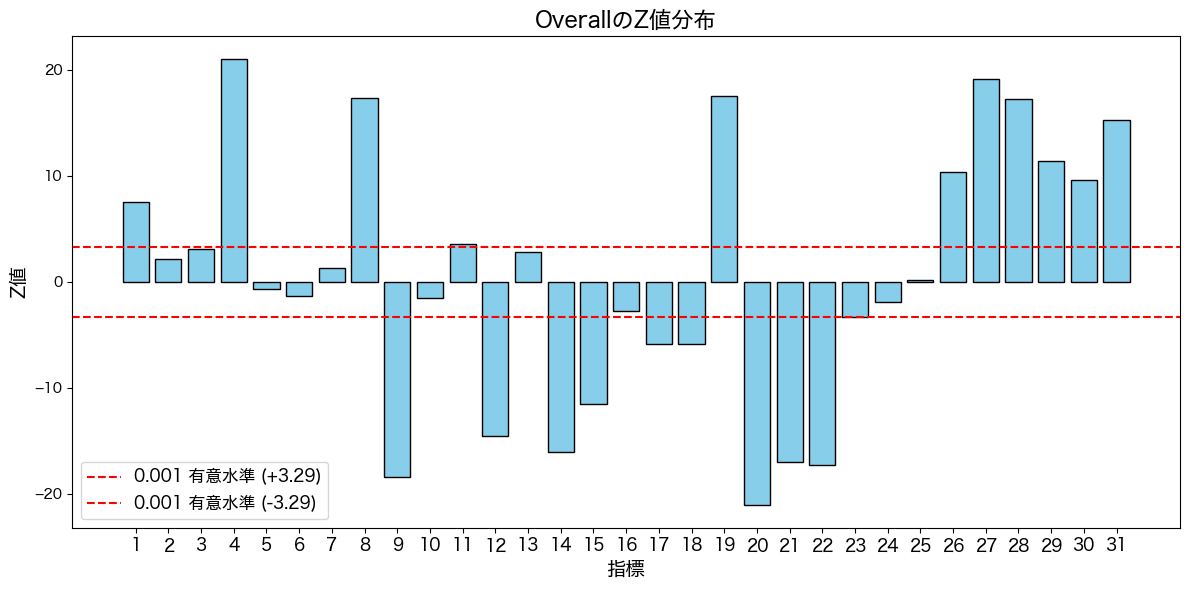

Yes比率のグラフを保存しました: ../../data/results/graphs/Biochemistry_Molecular_Biology_yes_ratio.png
データを保存しました: ../../data/results/metrics/Biochemistry_Molecular_Biology_results.csv
グラフを保存しました: ../../data/results/graphs/Biochemistry_Molecular_Biology_ztest_visualization.png


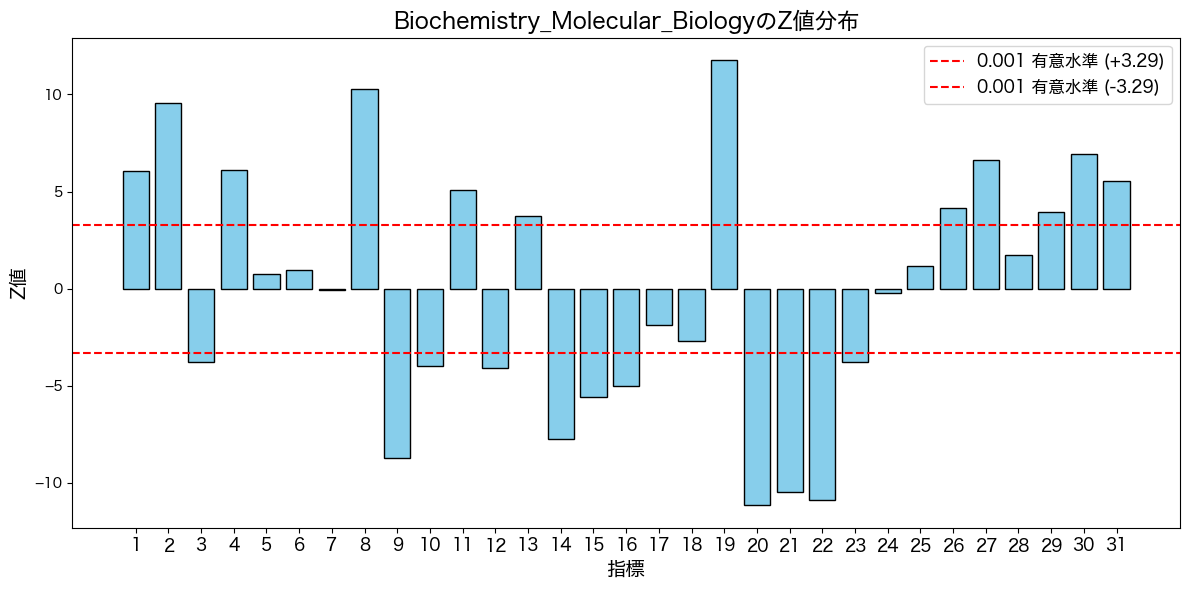

Yes比率のグラフを保存しました: ../../data/results/graphs/Physics_yes_ratio.png
データを保存しました: ../../data/results/metrics/Physics_results.csv
グラフを保存しました: ../../data/results/graphs/Physics_ztest_visualization.png


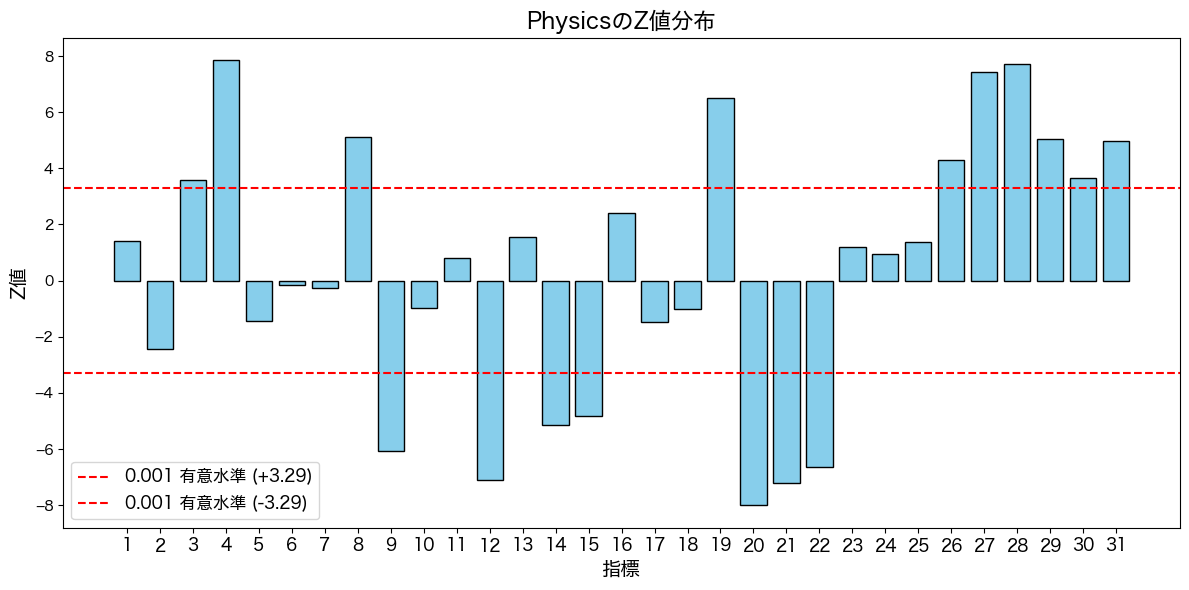

Yes比率のグラフを保存しました: ../../data/results/graphs/Chemistry_yes_ratio.png
データを保存しました: ../../data/results/metrics/Chemistry_results.csv
グラフを保存しました: ../../data/results/graphs/Chemistry_ztest_visualization.png


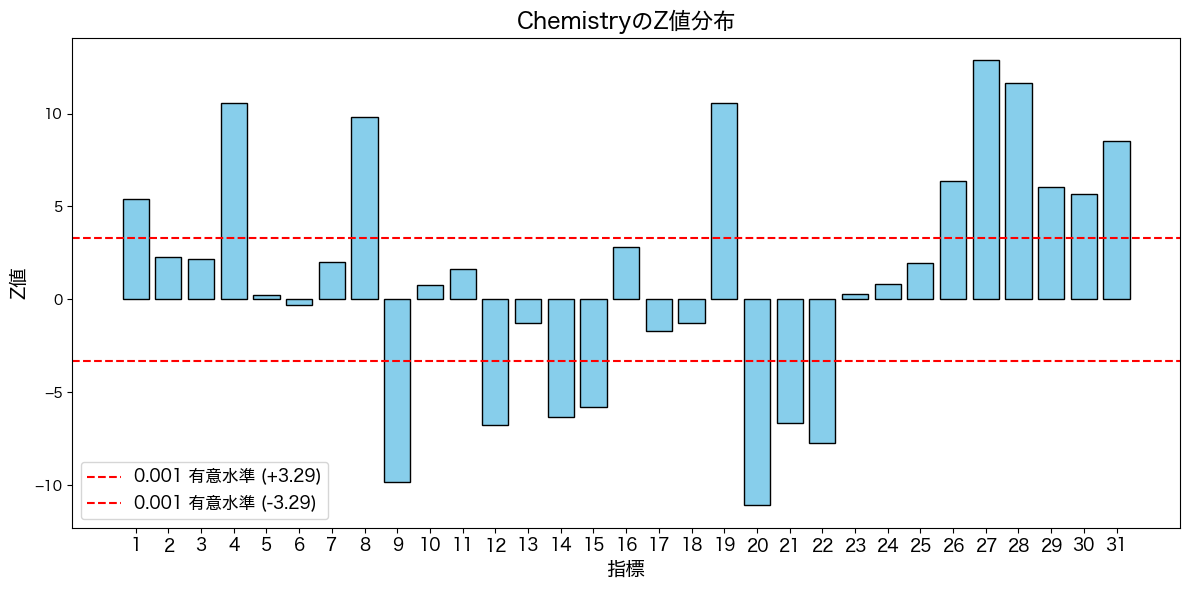

Yes比率のグラフを保存しました: ../../data/results/graphs/Materials_Science_yes_ratio.png
データを保存しました: ../../data/results/metrics/Materials_Science_results.csv
グラフを保存しました: ../../data/results/graphs/Materials_Science_ztest_visualization.png


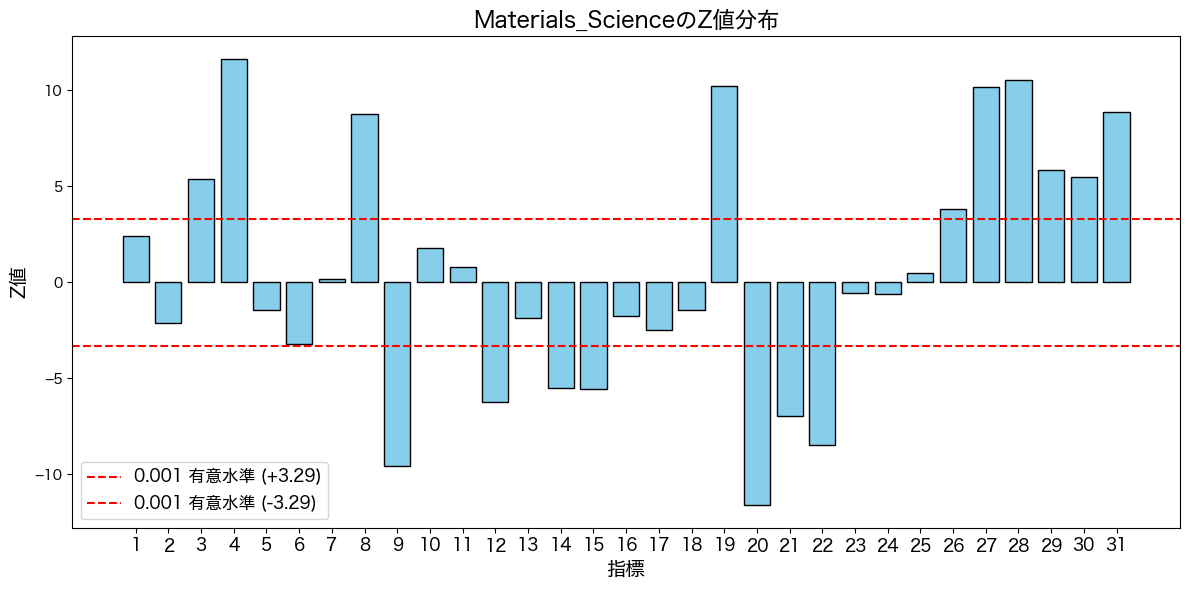

Yes比率のグラフを保存しました: ../../data/results/graphs/Engineering_yes_ratio.png
データを保存しました: ../../data/results/metrics/Engineering_results.csv
グラフを保存しました: ../../data/results/graphs/Engineering_ztest_visualization.png


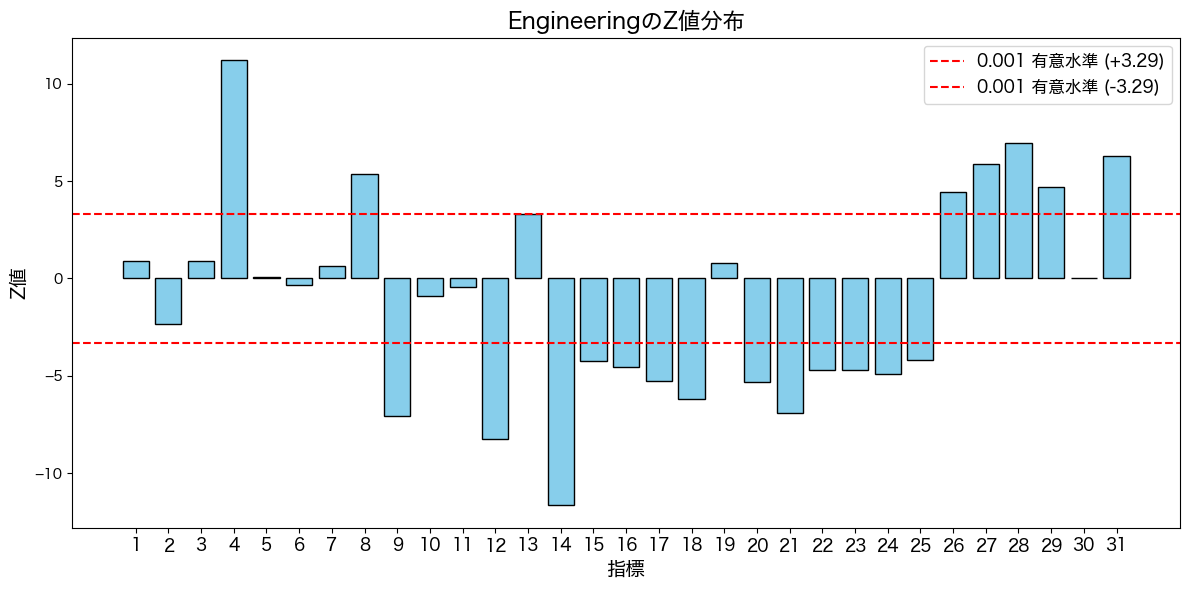

In [ ]:
# 各分野ごとの比較
for field in high_group.keys():
    
    # データ前処理
    high_df = preprocess_data(high_group[field])
    low_df = preprocess_data(low_group[field])
    
    # 指標ごとのyes比率を計算
    high_ratios = calculate_yes_ratios(high_df, rules)
    low_ratios = calculate_yes_ratios(low_df, rules)
    field_ratios_path = f"{data_save_dir}/{field}_yes_ratios.csv"
    pd.concat([high_ratios, low_ratios], axis=1).to_csv(field_ratios_path, index=False)
    
    # 比率グラフの保存
    save_yes_ratio_graph(
        high_ratios,
        low_ratios,
        graph_save_dir,
        field
    )
    
    # Z検定
    results_df = calculate_ztest(high_df, low_df, rules)
    
    # 可視化と保存
    visualize_results(results_df, graph_save_dir, data_save_dir, field)
